In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import pingouin as pg

df = pd.read_csv('data/survey_results_public.csv')

##
## Stop outs from using scientific notation
##
pd.set_option('display.float_format', '{:.6f}'.format)

##
## Filtering responses which are not professional software developers in USA, UK or Germany that provided compensation information
##
df.dropna(subset=['CompTotal'], inplace=True)
df = df[df['MainBranch'] == 'I am a developer by profession']
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['Currency'].isin(['EUR European Euro', 'USD\tUnited States dollar', 'GBP\tPound sterling'])]
df = df[df[['Currency', 'Country']].apply(tuple, axis=1).isin([('USD\tUnited States dollar', 'United States of America'), ('EUR European Euro', 'Germany'), ('GBP\tPound sterling', 'United Kingdom of Great Britain and Northern Ireland')])]
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['DevType'].str.contains('Developer', na=False)]

##
## Drop columns which are not used
##

df = df[['EdLevel',
         'LearnCode', 
         'LearnCodeOnline', 
         'YearsCode', 
         'YearsCodePro', 
         'DevType', 
         'Country', 
         'LanguageHaveWorkedWith', 
         'LanguageWantToWorkWith', 
         'PlatformHaveWorkedWith', 
         'PlatformWantToWorkWith',
         'WebframeHaveWorkedWith', 
         'WebframeWantToWorkWith', 
         'EmbeddedHaveWorkedWith', 
         'EmbeddedWantToWorkWith', 
         'MiscTechHaveWorkedWith', 
         'MiscTechWantToWorkWith', 
         'ToolsTechHaveWorkedWith', 
         'ToolsTechWantToWorkWith', 
         'WorkExp', 
         'ConvertedCompYearly']]

##
## Break the "HaveWorkdWith" and "WantToWorkWith" columns down into a column for each language
##

WorkWithList = [
    'LanguageHaveWorkedWith', 
    'LanguageWantToWorkWith', 
    'PlatformHaveWorkedWith', 
    'PlatformWantToWorkWith',
    'WebframeHaveWorkedWith', 
    'WebframeWantToWorkWith', 
    'EmbeddedHaveWorkedWith', 
    'EmbeddedWantToWorkWith', 
    'MiscTechHaveWorkedWith', 
    'MiscTechWantToWorkWith', 
    'ToolsTechHaveWorkedWith', 
    'ToolsTechWantToWorkWith'
]

for WorkWith in WorkWithList:
    df_workwith = df[WorkWith].str.get_dummies(sep=';')
    df_workwith = df_workwith.add_prefix(WorkWith + '_')
    df = pd.concat([df, df_workwith], axis=1)

##
## Set a numerical value for each education level
##

education_mapping = {
    'Primary/elementary school': 1,
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2,
    'Some college/university study without earning a degree': 3,
    'Associate degree (A.A., A.S., etc.)': 4,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 6,
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 7
}
df['EdLevelNumeric'] = df['EdLevel'].map(education_mapping)

##
## Drop known bad cols which contain very little to no data
##

cols_to_drop = [
    'PlatformWantToWorkWith_PythonAnywhere', 
    'WebframeWantToWorkWith_Yii 2', 
    'EmbeddedHaveWorkedWith_CUTE'
]
df = df.drop(columns=cols_to_drop)

##
## Create a dataframe per country
##

df_GER = df[df['Country'] == 'Germany']
df_UK  = df[df['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
df_USA = df[df['Country'] == 'United States of America']


##
## Remove Non Numeric Columns
##
df_GER = df_GER.select_dtypes(include='number')
df_UK  = df_UK.select_dtypes(include='number')
df_USA = df_USA.select_dtypes(include='number')


In [14]:
##
## Perform a partical correlation between each variable and Total Compensation.
##

dependent = 'ConvertedCompYearly'

corr_array_list = []
for country, df in [["GER",df_GER], ["UK", df_UK], ["USA",df_USA]]:

    independent_list = df.columns.tolist()
    independent_list.remove(dependent)

    array = pd.DataFrame()
    for independent in independent_list:

        corr = pg.partial_corr(data=df, 
                               x=independent, 
                               y=dependent, 
                               method='spearman')
        corr.index.values[0] = independent
        array = pd.concat([array, corr])

    array = array.add_prefix(country + '_')
    corr_array_list.append(array)

corr_df = pd.concat(corr_array_list, axis=1)

corr_df['avg_r'] = corr_df[['GER_r', 'USA_r', 'UK_r']].mean(axis=1)
corr_df = corr_df.sort_values(by='avg_r', ascending=False)

display(corr_df)

corr_df.to_csv('calculated_correlations.csv')


/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:877: RuntimeWarning: invalid value encountered in divide
  / np.sqrt(np.abs(Vi_diag - Vi**2 / Vi_diag[..., None])).T
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  #

,GER_n,GER_r,GER_CI95%,GER_p-val,UK_n,UK_r,UK_CI95%,UK_p-val,USA_n,USA_r,USA_CI95%,USA_p-val,avg_r
WorkExp,905,0.514256,"[0.46, 0.56]",0.000000,671,0.412203,"[0.35, 0.47]",0.000000,2291,0.382118,"[0.35, 0.42]",0.000000,0.436192
EdLevelNumeric,1180,0.351290,"[0.3, 0.4]",0.000000,913,0.172038,"[0.11, 0.23]",0.000000,3097,0.136315,"[0.1, 0.17]",0.000000,0.219881
PlatformHaveWorkedWith_Amazon Web Services (AWS),1202,0.201221,"[0.15, 0.25]",0.000000,921,0.186091,"[0.12, 0.25]",0.000000,3102,0.194690,"[0.16, 0.23]",0.000000,0.194001
ToolsTechHaveWorkedWith_Terraform,1202,0.198164,"[0.14, 0.25]",0.000000,921,0.167319,"[0.1, 0.23]",0.000000,3102,0.183067,"[0.15, 0.22]",0.000000,0.182850
ToolsTechHaveWorkedWith_Kubernetes,1202,0.157696,"[0.1, 0.21]",0.000000,921,0.219061,"[0.16, 0.28]",0.000000,3102,0.157023,"[0.12, 0.19]",0.000000,0.177927
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WebframeHaveWorkedWith_jQuery,1202,-0.153361,"[-0.21, -0.1]",0.000000,921,-0.151405,"[-0.21, -0.09]",0.000004,3102,-0.148428,"[-0.18, -0.11]",0.000000,-0.151065
LanguageWantToWorkWith_HTML/CSS,1202,-0.177781,"[-0.23, -0.12]",0.000000,921,-0.136309,"[-0.2, -0.07]",0.000033,3102,-0.140234,"[-0.17, -0.11]",0.000000,-0.151441
LanguageHaveWorkedWith_C#,1202,-0.123441,"[-0.18, -0.07]",0.000018,921,-0.178627,"[-0.24, -0.12]",0.000000,3102,-0.181555,"[-0.22, -0.15]",0.000000,-0.161208
LanguageHaveWorkedWith_PHP,1202,-0.176109,"[-0.23, -0.12]",0.000000,921,-0.167646,"[-0.23, -0.1]",0.000000,3102,-0.149162,"[-0.18, -0.11]",0.000000,-0.164306


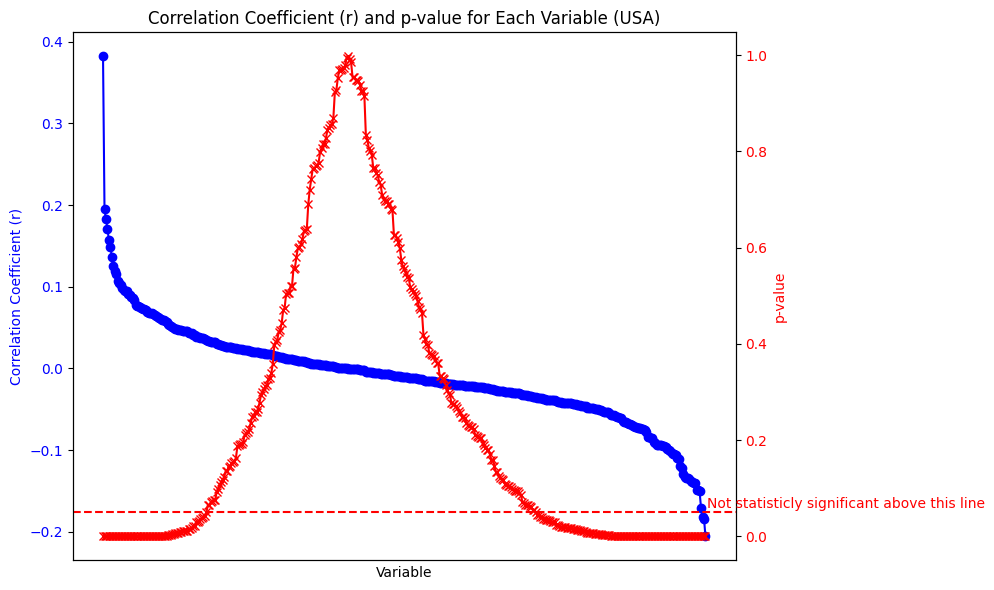

In [17]:
import matplotlib.pyplot as plt

corr_df = corr_df.sort_values(by='USA_r', ascending=False)

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Variable')
ax1.set_ylabel('Correlation Coefficient (r)', color='blue')
ax1.plot(corr_df.index, corr_df['USA_r'], marker='o', color='blue', label='r')
ax1.tick_params(axis='y', labelcolor='blue')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


ax2 = ax1.twinx() 
ax2.set_ylabel('p-value', color='red')
ax2.plot(corr_df.index, corr_df['USA_p-val'], marker='x', color='red', label='p-val')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
ax2.text(len(corr_df.index)-0.05, 0.05+0.01, 'Not statisticly significant above this line', color='red')

plt.title('Correlation Coefficient (r) and p-value for Each Variable (USA)')

# Display the plot
plt.tight_layout()
plt.savefig('randp.png', format='png')
plt.show()

